In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('../..')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../../sci_style.py')

# Load Data

In [3]:
# # session = 'Mary-Anesthesia-20160912-02'
# # session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160105-01'

# session_list = ['Mary-Anesthesia-20160912-02',
# 'MrJones-Anesthesia-20160109-01',
# 'Mary-Anesthesia-20160826-02',
# 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

session_list = os.listdir(results_dir)

In [4]:
session = session_list[0]

In [6]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)

In [7]:
print("loading directory")
    
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

print("directory loaded!")


loading directory
directory loaded!


In [61]:
norm_folder = "NOT_NORMED"
# -----------------------------------------
# LOAD GRID RESULTS
# -----------------------------------------

session_results = {}
session_results[session] = {}
# data_processing_df_grid = deepcopy(mp_args.data_processing_df)

grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

for area in areas:
    df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
    for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
        t = float(f.split('_')[0])
        file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
        df_new = pd.DataFrame(pd.read_pickle(file_path))
        if np.isnan(df_new.AIC).sum() > 0:
            print(file_path)
        df_new = df_new.set_index(['window', 'matrix_size', 'r'])
        for i, row in df_new.iterrows():
            if i in df.index:
                df.loc[i, 'AICs'].append(row.AIC)
                df.loc[i, 'time_vals'].append(t)
                df.loc[i, 'file_paths'].append(file_path)
            else:
                df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

    df = df.loc[df.index.sortlevel()[0]]
    session_results[session][area] = df

print("Grid search results loaded!")

# ================
# INDIVIDUAL AREAS
# ================ 
window, matrix_size, r, all_results = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

# ================
# ALL AREAS
# ================ 
if 'all' in session_results[session].keys():
    window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})


Grid search results loaded!


In [57]:
area = 'all'
if area == 'all':
    electrode_indices = np.arange(len(electrode_info['area']))
else:
    electrode_indices = np.where(electrode_info['area'] == area)[0]

In [63]:
if area == 'all':
    wake_signal = load_window_from_chunks(300, 300 + window_all*dt, directory, dimension_inds=electrode_indices)
    anesthesia_signal = load_window_from_chunks(3500, 3500 + window_all*dt, directory, dimension_inds=electrode_indices)
else:
    wake_signal = load_window_from_chunks(300, 300 + window*dt, directory, dimension_inds=electrode_indices)
    anesthesia_signal = load_window_from_chunks(3500, 3500 + window*dt, directory, dimension_inds=electrode_indices)

In [64]:
if area == 'all':
    delase_wake = DeLASE(wake_signal, matrix_size=matrix_size_all, dt=dt, use_torch=True, device='cuda')
    delase_anesthesia = DeLASE(anesthesia_signal, matrix_size=matrix_size_all, dt=dt, use_torch=True, device='cuda')
else:
    delase_wake = DeLASE(wake_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
    delase_anesthesia = DeLASE(anesthesia_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')

In [65]:
if area == 'all':
    delase_wake.compute_havok_dmd(r=r_all)
    delase_anesthesia.compute_havok_dmd(r=r_all)
else:
    delase_wake.compute_havok_dmd(r=r)
    delase_anesthesia.compute_havok_dmd(r=r)

In [66]:
delase_wake.get_stability(max_freq=500, max_unstable_freq=125)
delase_anesthesia.get_stability(max_freq=500, max_unstable_freq=125)

In [67]:
stab_old_wake = deepcopy(delase_wake.stability_params)
stab_old_anesthesia = deepcopy(delase_anesthesia.stability_params)

In [70]:
delase_wake.N_time_bins

4

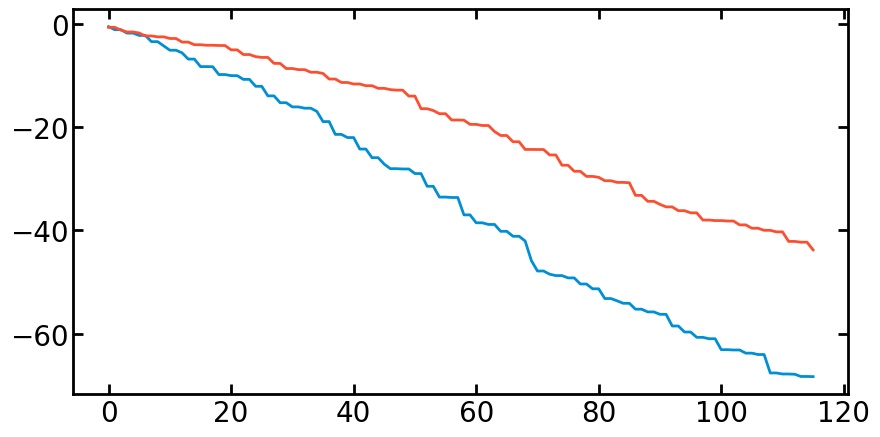

In [68]:
plt.plot(stab_old_wake[:int(len(stab_old_wake)*0.1)].cpu())
plt.plot(stab_old_anesthesia[:int(len(stab_old_anesthesia)*0.1)].cpu())
plt.show()

In [71]:
delase_wake.get_stability(N_time_bins=30, max_freq=500, max_unstable_freq=125)
delase_anesthesia.get_stability(N_time_bins=30, max_freq=500, max_unstable_freq=125)

In [72]:
stab_new_wake = deepcopy(delase_wake.stability_params)
stab_new_anesthesia = deepcopy(delase_anesthesia.stability_params)

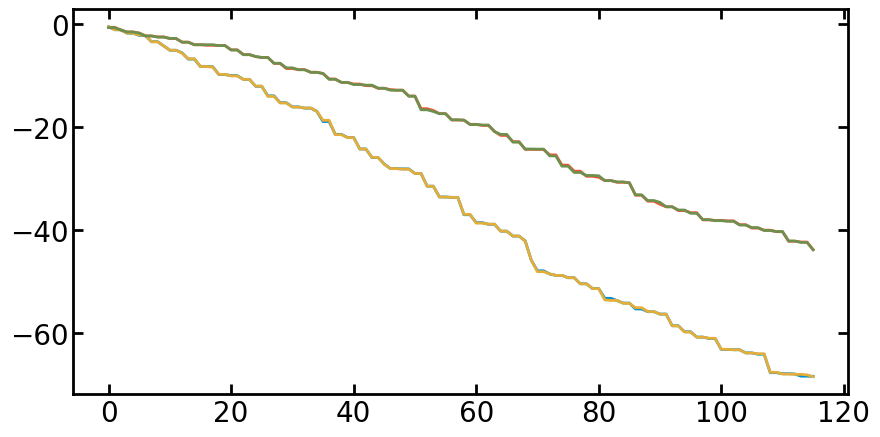

In [73]:
plt.plot(stab_old_wake[:int(len(stab_old_wake)*0.1)].cpu())
plt.plot(stab_old_anesthesia[:int(len(stab_old_anesthesia)*0.1)].cpu())
plt.plot(stab_new_wake[:int(len(stab_old_wake)*0.1)].cpu())
plt.plot(stab_new_anesthesia[:int(len(stab_old_anesthesia)*0.1)].cpu())